In [ ]:
import zipfile

!wget http://press.liacs.nl/mirflickr/mirflickr25k.v3b/mirflickr25k.zip

--2023-07-25 15:08:09--  http://press.liacs.nl/mirflickr/mirflickr25k.v3b/mirflickr25k.zip
Resolving press.liacs.nl (press.liacs.nl)... 132.229.137.37
Connecting to press.liacs.nl (press.liacs.nl)|132.229.137.37|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://press.liacs.nl/mirflickr/mirflickr25k.v3b/mirflickr25k.zip [following]
--2023-07-25 15:08:09--  https://press.liacs.nl/mirflickr/mirflickr25k.v3b/mirflickr25k.zip
Connecting to press.liacs.nl (press.liacs.nl)|132.229.137.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3069184257 (2.9G) [application/zip]
Saving to: ‘mirflickr25k.zip’

mirflickr25k.zip    100%[===================>]   2.86G  23.0MB/s    in 2m 14s  

2023-07-25 15:10:23 (21.9 MB/s) - ‘mirflickr25k.zip’ saved [3069184257/3069184257]



In [ ]:
zipped_file = zipfile.ZipFile("mirflickr25k.zip")
zipped_file.extractall()
zipped_file.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from SRGAN import create_gen, create_dis, create_gan
from utils import train
import tensorflow as tf
from keras.applications import VGG19
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import random

In [ ]:
train_dir = "mirflickr"
save_dir = "drive/MyDrive/dl/datasets/srgan_train_dataset"

In [ ]:
#note to self: only run once

# for img in tqdm(os.listdir(train_dir)):
#   if img[-4:] ==".jpg":
#     img_array = cv2.imread(train_dir+"/"+img)
#     try:
#       img_array = cv2.resize(img_array, (128, 128))
#       lr_img_array = cv2.resize(img_array, (32, 32))
#       cv2.imwrite(save_dir+"/hr_images/"+img, img_array)
#       cv2.imwrite(save_dir+"/lr_images/"+img, lr_img_array)

#     except Exception as e:
#       print(str(e))


  0%|          | 0/25002 [00:00<?, ?it/s]

In [ ]:
lr_dir = save_dir+"/lr_images"
hr_dir = save_dir+"/hr_images"

In [ ]:
lr_list = os.listdir(lr_dir)
hr_list = os.listdir(hr_dir)
len(lr_list), len(hr_list)

In [ ]:
lr_list = os.listdir(lr_dir)
lr_images = []

for img in tqdm(lr_list):
  img_lr = cv2.imread(lr_dir+"/"+img)
  img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
  lr_images.append(img_lr/255)

hr_list = os.listdir(hr_dir)
hr_images = []

for img in tqdm(hr_list):
  img_hr = cv2.imread(hr_dir+"/"+img)
  img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
  hr_images.append(img_hr/255)

np.save("drive/MyDrive/dl/datasets/srgan_train_dataset/lr_images.npy", np.array(lr_images))
np.save("drive/MyDrive/dl/datasets/srgan_train_dataset/hr_images.npy", np.array(hr_images))

  0%|          | 0/19089 [00:00<?, ?it/s]

  0%|          | 0/19089 [00:00<?, ?it/s]

In [ ]:
# lr_images = np.load("drive/MyDrive/dl/datasets/srgan_train_dataset/lr_images.npy")
# hr_images = np.load("drive/MyDrive/dl/datasets/srgan_train_dataset/hr_images.npy")

In [ ]:
lr_train, lr_test, hr_train, hr_test = train_test_split(
    np.load("drive/MyDrive/dl/datasets/srgan_train_dataset/lr_images.npy"),
    np.load("drive/MyDrive/dl/datasets/srgan_train_dataset/hr_images.npy"),
    test_size=0.00001, random_state=42)

In [ ]:
def build_vgg(hr_shape):
  vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)
  return tf.keras.Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [ ]:
hr_shape = (128, 128, 3)
lr_shape = (32, 32, 3)

lr_ip = tf.keras.layers.Input(shape=lr_shape)
hr_ip = tf.keras.layers.Input(shape=hr_shape)

In [ ]:
generator = create_gen(lr_ip, 16)

In [ ]:
discriminator = create_dis(hr_ip)
discriminator.compile(loss="binary_crossentropy",
                      optimizer="adam",
                      metrics=["accuracy"])

In [ ]:
vgg = build_vgg((128, 128, 3))
vgg.trainable=False

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
gan_model = create_gan(generator, discriminator, vgg, lr_ip, hr_ip)

In [ ]:
gan_model.compile(loss=["binary_crossentropy", "mse"],
                  loss_weights=[1e-3, 1],
                  optimizer="adam",
                  metrics=["accuracy"])

##Training

In [ ]:
batch_size = 1

In [ ]:
train_lr_batch, train_hr_batch = [], []
for i in range(int(hr_train.shape[0]/batch_size)):
  start = i*batch_size
  end = start + batch_size

  train_hr_batch.append(hr_train[start:end])
  train_lr_batch.append(lr_train[start:end])

In [ ]:
generator.load_weights("SRGAN_10e_extended_(40l).h5")

In [ ]:
# 11th epoch
train(gan_model, generator, discriminator,
      vgg, epochs=1,
      train_lr=train_lr_batch,
      train_hr=train_hr_batch,
      batch_size=1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19088 [00:00<?, ?it/s]

g_loss:17.527843475341797, d_loss:0.0014287537205746048epoch:1 g_loss:57.16309639952659, d_loss:0.3176332718068511


##Testing


In [ ]:
generator_4e = create_gen(lr_ip, 16)
generator_10e = create_gen(lr_ip, 16)
temp = tf.zeros(shape=(1, 32, 32, 3))
_, _ = generator_4e(temp), generator_10e(temp)

In [ ]:
generator_4e.load_weights("SRGAN_4e_+2.h5")
generator_10e.load_weights("SRGAN_10e_extended_(40l).h5")

In [ ]:
def min_max_norm(input):
  min_value = tf.reduce_min(input)
  max_value = tf.reduce_max(input)

  return (input - min_value) / (max_value - min_value)

In [ ]:
def inference():
  idx = random.randint(1, 25_000)

  hr_demo = cv2.imread(f"drive/MyDrive/dl/datasets/srgan_train_dataset/hr_images/im{idx}.jpg")
  lr_demo = cv2.imread(f"drive/MyDrive/dl/datasets/srgan_train_dataset/lr_images/im{idx}.jpg")
  lr_demo = cv2.cvtColor(lr_demo, cv2.COLOR_BGR2RGB)
  hr_demo = cv2.cvtColor(hr_demo, cv2.COLOR_BGR2RGB)

  lr_demo = lr_demo/255
  hr_demo = hr_demo/255

  lr_demo = np.expand_dims(lr_demo, axis=0)
  hr_demo = np.expand_dims(hr_demo, axis=0)

  generated_4e = generator_4e.predict(lr_demo, verbose=0)
  generated_10e = generator_10e.predict(lr_demo, verbose=0)

  plt.figure(figsize=(10, 10))
  plt.subplot(1, 4, 1)
  plt.title("low res image")
  plt.imshow(lr_demo[0])
  plt.subplot(1, 4, 2)
  plt.title("SRGAN generated (4e)")
  plt.imshow(min_max_norm(generated_4e[0]))
  plt.subplot(1, 4, 3)
  plt.title("SRGAN generated (10e)")
  plt.imshow(min_max_norm(generated_10e[0]))
  plt.subplot(1, 4, 4)
  plt.title("original image")
  plt.imshow(hr_demo[0])
  plt.show()

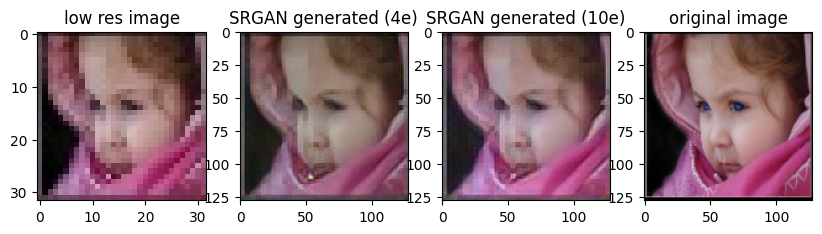

In [ ]:
inference()

## Experimenting with 2 iterations of SRGAN

In [ ]:
!pip -q install patchify

In [ ]:
from patchify import patchify, unpatchify

In [ ]:
hr_demo = cv2.imread(f"drive/MyDrive/dl/datasets/srgan_train_dataset/hr_images/im154.jpg")
lr_demo = cv2.imread(f"drive/MyDrive/dl/datasets/srgan_train_dataset/lr_images/im154.jpg")
lr_demo = cv2.cvtColor(lr_demo, cv2.COLOR_BGR2RGB)
hr_demo = cv2.cvtColor(hr_demo, cv2.COLOR_BGR2RGB)

lr_demo = lr_demo/255
hr_demo = hr_demo/255

lr_demo = np.expand_dims(lr_demo, axis=0)
hr_demo = np.expand_dims(hr_demo, axis=0)

In [ ]:
generated_hr = generator_10e.predict(lr_demo, verbose=0)

In [ ]:
patched_hr = patchify(generated_hr[0], (32, 32, 3), step=32)
patched_hr[0][0].shape

(1, 32, 32, 3)

In [ ]:
patched_res = np.zeros(shape=(4, 4, 1, 128, 128, 3))
patched_res.shape

(4, 4, 1, 128, 128, 3)

In [ ]:
for i in range(4):
  for j in range(4):
    patched_res[i][j][0]= generator_10e.predict(patched_hr[i][j], verbose=0)

In [ ]:
patched_hr = unpatchify(patched_res, (512, 512, 3))

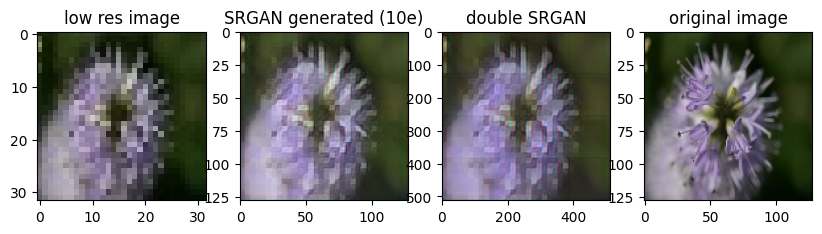

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.title("low res image")
plt.imshow(lr_demo[0])
plt.subplot(1, 4, 2)
plt.title("SRGAN generated (10e)")
plt.imshow(min_max_norm(generated_hr[0]))
plt.subplot(1, 4, 3)
plt.title("double SRGAN")
plt.imshow(min_max_norm(patched_hr))
plt.subplot(1, 4, 4)
plt.title("original image")
plt.imshow(hr_demo[0])
plt.show()